# Bayesian optimization (BO) - find the minimum value of 1 variable function
Reference: <br>
https://datachemeng.com/bayesianoptimization/ <br>
http://krasserm.github.io/2018/03/21/bayesian-optimization/ <br>
https://orbi.uliege.be/bitstream/2268/226433/1/PyData%202017_%20Bayesian%20optimization%20with%20Scikit-Optimize.pdf <br>
https://github.com/Ma-sa-ue/practice/blob/master/machine%20learning(python)/bayeisan_optimization.ipynb

In [1]:
import numpy as np
import pandas as pd
import GPy
import GPyOpt
from numpy.random import seed
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [2]:
# Definition of a black-box function to understand the concept
def f_y(x) :
    y = -np.abs(x * np.sin(x * np.pi/60.0) + 20)
    return y

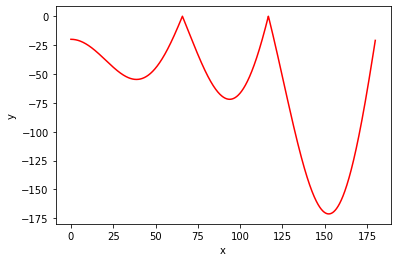

In [3]:
# Draw black-box function
x = np.arange(0, 180, 0.1)
y = f_y(x)
plt.plot(x, y, c = 'r')
plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [4]:
# Make dataframe x, y
df_xy = pd.DataFrame()
df_xy['x'] = x
df_xy['y'] = f_y(x)
print(df_xy.shape)
df_xy.head()

(1800, 2)


,x,y
0,0.0,-20.000000
1,0.1,-20.000524
2,0.2,-20.002094
3,0.3,-20.004712
4,0.4,-20.008377


In [5]:
# Check x, y at the minimum y position
min_y = np.argmin(np.array(df_xy['y']))
print('Minimum "y" index = ', min_y)
df_xy.loc[min_y]

Minimum "y" index =  1524


x    152.40000
y   -171.19828
Name: 1524, dtype: float64

In [6]:
# Random x generation
init_exp_num = 10

np.random.seed(5)
rnd_idx_initial = [np.random.randint(0, len(df_xy)) for i in range(init_exp_num)]
print(rnd_idx_initial)

[867, 206, 1725, 998, 1142, 1424, 73, 1032, 740, 1767]


In [7]:
# The initial dataframe of x, y 
df_xy_initial = df_xy.loc[rnd_idx_initial]
df_xy_initial

,x,y
867,86.7,-65.408979
206,20.6,-38.154851
1725,172.5,-86.012892
998,99.8,-66.947138
1142,114.2,-14.150458
1424,142.4,-151.273313
73,7.3,-22.722811
1032,103.2,-59.516967
740,74.0,-29.515665
1767,176.7,-50.379872


In [8]:
# Determine explanatory variables X and target variable y
X = df_xy_initial['x']
y = df_xy_initial['y']

In [9]:
# Make the initial dataset to train the first model even though sample size is very small
X_train_init = np.array(X)
X_test  = np.array(X)
y_train_init = np.array(y)
y_test  = np.array(y)

print('The initial experiment x, y')
print('x = ', X_train_init)
print('y = ', y_train_init)

The initial experiment x, y
x =  [ 86.7  20.6 172.5  99.8 114.2 142.4   7.3 103.2  74.  176.7]
y =  [ -65.40897858  -38.15485111  -86.01289208  -66.94713835  -14.15045848
 -151.27331279  -22.72281081  -59.51696665  -29.51566487  -50.37987202]


### Make GPR models

In [10]:
# Dictionary of kernel
kernel_dict = {1:GPy.kern.RBF(1),
               2:GPy.kern.RBF(1) + GPy.kern.Bias(1) + GPy.kern.Linear(1),
               3:GPy.kern.PeriodicMatern32(1) * GPy.kern.RBF(1),
               4:GPy.kern.Exponential(1),
               5:GPy.kern.Exponential(1) * GPy.kern.RBF(1) + GPy.kern.White(1)}

In [11]:
# Select a suitable GPR kernel
kernel = kernel_dict[5]

In [12]:
def MakeModel(X, y, kern):
    model = GPy.models.GPRegression(X.reshape(-1, 1), y.reshape(-1, 1), kernel = kern)
    model.optimize()
    
    #print(model)
    model.plot()
    plt.show()
    
    return model

### GPR model for the initial experiment points

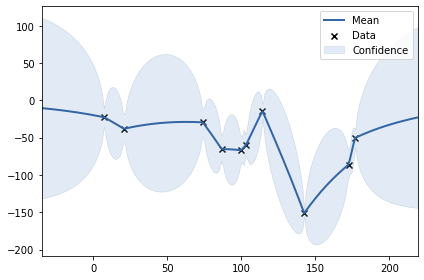

In [13]:
loop_model = MakeModel(X_train_init, y_train_init, kernel)

### Adaptive DOE stage from here

In [14]:
# Bounds : the range of variables
bounds = [
    {'name': 'x',
     'type': 'continuous',
     'domain': (0.0, 180.0)}
]

# Iteration to find the next point
Bayesian_opt_iter = 1 

In [15]:
# The function that want to mimimize (or maximize by multiplied by -1)

def my_f(X):
    y = loop_model.predict(X)[0]   # return only the mean value
    return y

In [16]:
# Bayesian optimization for adaptive DOE

myProblem = GPyOpt.methods.BayesianOptimization(my_f, bounds)
myProblem.run_optimization(Bayesian_opt_iter)
    
X_opt = myProblem.x_opt
y_opt = f_y(X_opt)

In [17]:
X_new = np.append(X_train_init, X_opt)
y_new = np.append(y_train_init, y_opt)

Sampling number =  40


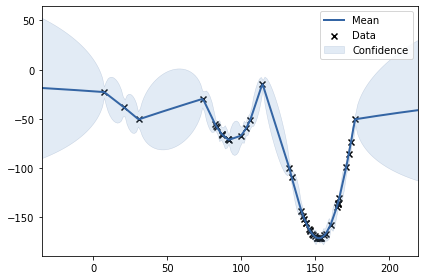

In [18]:
# Interation for adaptive DOE

iter_BO = 40

for i in range(iter_BO - 1):
    #print('Sampling number = ', i)
    loop_model = MakeModel(X_new, y_new, kernel)
    myProblem = GPyOpt.methods.BayesianOptimization(my_f, bounds)
    myProblem.run_optimization(Bayesian_opt_iter)
    
    X_opt = myProblem.x_opt
    y_opt = f_y(X_opt)
    X_new = np.append(X_new, X_opt)
    y_new = np.append(y_new, y_opt)
    clear_output(True)

print('Sampling number = ', iter_BO)
loop_model = MakeModel(X_new, y_new, kernel)
myProblem = GPyOpt.methods.BayesianOptimization(my_f, bounds)
myProblem.run_optimization(Bayesian_opt_iter)

X_opt = myProblem.x_opt
y_opt = f_y(X_opt)
X_new = np.append(X_new, X_opt)
y_new = np.append(y_new, y_opt)

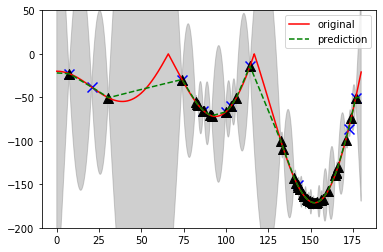

In [19]:
# Comparison with the hypothetical curve
x_o = np.arange(0, 180, 0.1)
y_o = f_y(x_o)
y_p  = loop_model.predict(x_o.reshape(-1, 1))[0][:,0]
y_sd = loop_model.predict(x_o.reshape(-1, 1))[1][:,0]

plt.plot(x_o, y_o, c = 'r', label = 'original')
plt.plot(x_o, y_p, c = 'g', label = 'prediction', linestyle = '--')

plt.fill_between(x_o, y_p+y_sd, y_p-y_sd, color = '#888888', alpha=0.4)

plt.scatter(df_xy_initial.iloc[:, 0], df_xy_initial.iloc[:, 1], c = 'b', marker = 'x', s = 100)
plt.scatter(X_new[3:], y_new[3:], marker = '^', c = 'k', s = 100)
plt.ylim(-200, 50)

plt.legend(loc = 'best')
plt.show()

### Additional experiments finished, so finally find the minimum value by BO

In [20]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f = my_f,
    domain = bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

optimizer.run_optimization(max_iter = 30)

In [21]:
print('minimum x = ', optimizer.x_opt)
print('minimum y = ', optimizer.fx_opt)

minimum x =  [152.76477313]
minimum y =  -171.15306366058712


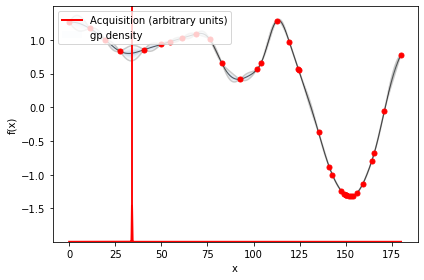

In [22]:
optimizer.plot_acquisition()

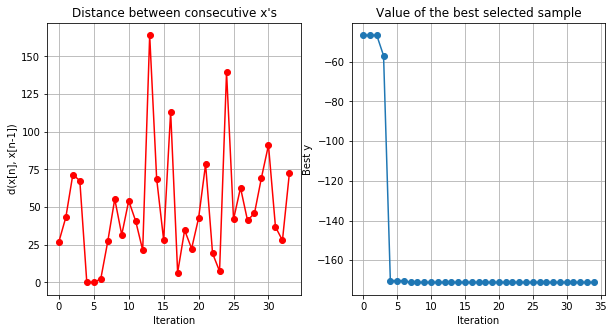

In [23]:
optimizer.plot_convergence()